<a href="https://colab.research.google.com/github/emery1189/evaluating_FENs/blob/main/FEN_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ♟️ Evaluating a FEN

**FEN** is the abbreviation of Forsyth-Edwards Notation; the standard notation to describe a position of a chess game. (Of course, one chess game can produce many different FENs.)

Using a [Kaggle Dataset](https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations?select=chessData.csv) of FENs and their evaluation in centipawns, we're going to attempt to create a model that can evaluate a chess position given a FEN.

A centipawn is the unit of measure used in chess as measure of the advantage. A centipawn is equal to 1/100 of a pawn. So if an evaluation is +100, white is up one pawn (or, in more human terms, +1). An evaluation of -100 would mean black is up a pawn (or, in more human terms, -1).

It may be worth noting that we're not attempting to teach a model to play chess. We are simply giving a model (FEN, evaluation) pairs in an attempt to see what the model may learn.


<font size=8>🪛 🪚 🛠️</font>

getting our data and tools

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.0 MB/s eta 0:00:00


In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download ronakbadhe/chess-evaluations

 97% 193M/200M [00:03<00:00, 71.7MB/s]
100% 200M/200M [00:03<00:00, 61.9MB/s]


In [4]:
!unzip /content/chess-evaluations.zip

Archive:  /content/chess-evaluations.zip
  inflating: chessData.csv           
  inflating: random_evals.csv        
  inflating: tactic_evals.csv        


In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import chess
import chess.svg
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from IPython.display import SVG, display

In [6]:
data = pd.read_csv("/content/chessData.csv")

data.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [7]:
data.describe()

,FEN,Evaluation
count,12958035,12958035
unique,12954834,13545
top,r1bq1rk1/pp3pbp/2np1np1/4p3/4PP2/1NN1B3/PPP1B1...,0
freq,3,1261356


we have nearly 13 million FENs with about 14,000 different evaluations.

it makes sense that each FEN does not have a unique evaluation: there are many, many different positions that all may be evaluated at, say, +4 (or +400 if we're measuring in centipawns).

13 million rows will crash our colab session, so we'll see what happens with 5% of the data.

In [8]:
X = data.FEN
y = data.Evaluation

fens_5, fens_95, evals_5, evals_95 = train_test_split(X, y, test_size=.95)

len(fens_5), len(evals_5)

(647901, 647901)

that gives us more than half a million positions and their evaluations to get started. let's take a look at a few.

In [9]:
fens_5[:5], evals_5[:5]

(3700833     4r2k/3r1qbp/3P1pp1/p1B2P2/b1pNP3/5B2/1P1R1QPP/...
 904943      rn1k4/p2p2p1/1p1Pp3/8/4n3/4P3/PP3PKP/R1B3R1 b ...
 6748078     2rr2k1/pbq1bppp/1pp1p3/4P3/3P1P2/2N1P3/PPQ3BP/...
 10459439    1r2nrk1/2q1p1bp/p2pPpp1/n1pP4/2P1QPP1/7P/PB1N2...
 12090145    r3kb1r/1pqbnp1p/p3p3/3pPp2/1P1P1P2/1NPQ1N2/6PP...
 Name: FEN, dtype: object,
 3700833      -61
 904943      +327
 6748078      +22
 10459439    +113
 12090145     -53
 Name: Evaluation, dtype: object)

In [10]:
sample_fens = [i for i in fens_5[:10]]
sample_evals = [i for i in evals_5[:10]]

wouldn't it be nice to have a way to see our FENs and evals in a more human friendly way?

## `show_position_and_eval()` function

In [11]:
def show_position_and_eval(FEN, eval):
  """
  takes a (FEN, eval) pair. displays the FEN as an SVG image and prints a message its associated evaluation.
  """
  b = chess.Board(FEN)
  c = chess.svg.board(b, size=375)
  d = SVG(c)
  display(d)
  print(f"\ncentipawn evaluation of ⬆️ position: {eval}")

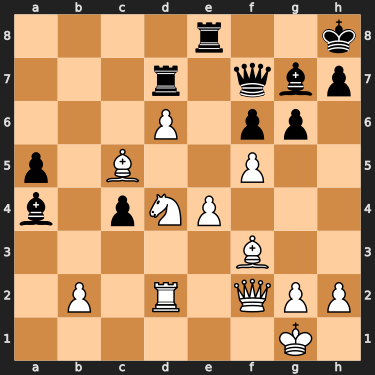


centipawn evaluation of ⬆️ position: -61


In [12]:
show_position_and_eval(sample_fens[0], sample_evals[0])

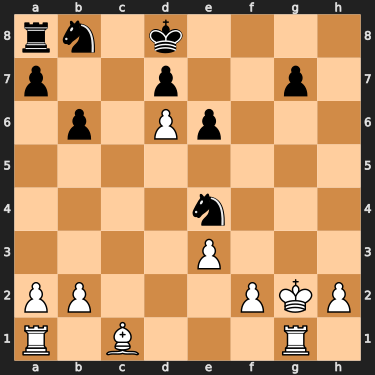


centipawn evaluation of ⬆️ position: +327


In [13]:
show_position_and_eval(sample_fens[1], sample_evals[1])

## `chess_dictionary`

we can create a dictionary of characters (each of which represents a chess piece or empty square) we find in FEN strings. we'll use the characters in the FENs as keys for our dicitonary; the values will be the numeric value of each piece (in centipawns).

we should be able to use this dictionary to create an (8, 8) tensor that represents the chess board and every piece on it.

that tensor should look like:
```
[
  [a8, b8, c8, d8, e8, f8, g8, h8],
  [a7, b7, c7, d7, e7, f7, g7, h7],
  ...
  [a1, b1, c1, d1, e1, f1, g1, h1]
]
```

note: the numeric value of a chess piece is not absolute. the values used in the below dictionary are approximate and intended to convey some subtleties of the game (while knights and bishops are often considered equal, bishops are usually worth slightly more; a rook is worth just a bit more than five pawns, etc.).

In [14]:
chess_dictionary = {"p" : -100,
                   "n" : -310,
                   "b" : -325,
                   "r" : -510,
                   "q" : -910,
                   "k" : -10000,
                   "P" : 100,
                   "N" : 310,
                   "B" : 325,
                   "R" : 510,
                   "Q" : 910,
                   "K" : 10000,
                   "1" : 0,
                   "2" : (0, 0),
                   "3" : (0, 0, 0),
                   "4" : (0, 0, 0, 0),
                   "5" : (0, 0, 0, 0, 0,),
                   "6" : (0, 0, 0, 0, 0, 0),
                   "7" : (0, 0, 0, 0, 0, 0, 0),
                   "8" : (0, 0, 0, 0, 0, 0, 0, 0,)}

In [15]:
sample_fens[2].split("/")

['2rr2k1',
 'pbq1bppp',
 '1pp1p3',
 '4P3',
 '3P1P2',
 '2N1P3',
 'PPQ3BP',
 'R2R2K1 b - - 0 17']

In [16]:
fen_into_eight = sample_fens[2].split("/")
fen_into_eight_last_line = fen_into_eight[7].split()
pieces = fen_into_eight_last_line[0]
to_move = fen_into_eight_last_line[1]
castling = fen_into_eight_last_line[2]
fen_into_eight[7] = pieces

fen_into_eight

['2rr2k1', 'pbq1bppp', '1pp1p3', '4P3', '3P1P2', '2N1P3', 'PPQ3BP', 'R2R2K1']

In [17]:
fen_into_eight = sample_fens[2].split("/")
fen_into_eight_last_line = fen_into_eight[7].split()
pieces = fen_into_eight_last_line[0]
to_move = fen_into_eight_last_line[1]
castling = fen_into_eight_last_line[2]
fen_into_eight[7] = pieces
for each_row in range(len(fen_into_eight)):
  fen_into_eight[each_row] = [chess_dictionary[i] for i in fen_into_eight[each_row]]

fen_into_eight

[[(0, 0), -510, -510, (0, 0), -10000, 0],
 [-100, -325, -910, 0, -325, -100, -100, -100],
 [0, -100, -100, 0, -100, (0, 0, 0)],
 [(0, 0, 0, 0), 100, (0, 0, 0)],
 [(0, 0, 0), 100, 0, 100, (0, 0)],
 [(0, 0), 310, 0, 100, (0, 0, 0)],
 [100, 100, 910, (0, 0, 0), 325, 100],
 [510, (0, 0), 510, (0, 0), 10000, 0]]

we need to remove the tuples!

In [18]:
some_list = [2, (0, 0), 3, (0, 0, 0), 5]

for p in some_list:
    if isinstance(p, tuple):
      my_index = some_list.index(p)
      some_list[my_index] = 0
      print(f"index of tuple is {my_index}")
      w = len(p)
      print(f"w is {w}")
      p == 0
      for d in range(w - 1):
        some_list.insert((my_index + 1), 0)
        print("adding a zero")
    else:
      p = p

some_list

index of tuple is 1
w is 2
adding a zero
index of tuple is 4
w is 3
adding a zero
adding a zero


[2, 0, 0, 3, 0, 0, 0, 5]

In [19]:
fen_into_eight = sample_fens[2].split("/")
fen_into_eight_last_line = fen_into_eight[7].split()
pieces = fen_into_eight_last_line[0]
to_move = fen_into_eight_last_line[1]
castling = fen_into_eight_last_line[2]
fen_into_eight[7] = pieces
for each_row in range(len(fen_into_eight)):
  fen_into_eight[each_row] = [chess_dictionary[i] for i in fen_into_eight[each_row]]
  for each_square in range(len(fen_into_eight)):
    for square in fen_into_eight[each_square]:
      if isinstance(square, tuple):
        my_index = fen_into_eight[each_square].index(square)
        len_of_tuple = len(square)
        fen_into_eight[each_row][my_index] = 0
        for d in range(len_of_tuple - 1):
          fen_into_eight[each_row].insert((my_index + 1), 0)
      else:
        pass
fen_tensor = tf.convert_to_tensor(fen_into_eight)
fen_array = fen_tensor.numpy()
print(f"""
position as list:\n{fen_into_eight}\n\nto_move: {to_move}\n\ncastling: {castling}
      \n\nposition as tensor:\n{fen_tensor}\n⬆️ data type:{type(fen_tensor)}
      \n\ntensor as array:\n{fen_array}\n⬆️ data type:{type(fen_array)}
      """)


position as list:
[[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -325, -910, 0, -325, -100, -100, -100], [0, -100, -100, 0, -100, 0, 0, 0], [0, 0, 0, 0, 100, 0, 0, 0], [0, 0, 0, 100, 0, 100, 0, 0], [0, 0, 310, 0, 100, 0, 0, 0], [100, 100, 910, 0, 0, 0, 325, 100], [510, 0, 0, 510, 0, 0, 10000, 0]]

to_move: b

castling: -
      

position as tensor:
[[     0      0   -510   -510      0      0 -10000      0]
 [  -100   -325   -910      0   -325   -100   -100   -100]
 [     0   -100   -100      0   -100      0      0      0]
 [     0      0      0      0    100      0      0      0]
 [     0      0      0    100      0    100      0      0]
 [     0      0    310      0    100      0      0      0]
 [   100    100    910      0      0      0    325    100]
 [   510      0      0    510      0      0  10000      0]]
⬆️ data type:<class 'tensorflow.python.framework.ops.EagerTensor'>
      

tensor as array:
[[     0      0   -510   -510      0      0 -10000      0]
 [  -100   -325   -910    

## `fen_to_tensor()` function

In [20]:
def fen_to_tensor(fen_string):
  fen_into_eight = fen_string.split("/")
  fen_into_eight[7] = fen_into_eight[7].split()
  pieces = fen_into_eight[7][0]
  to_move = fen_into_eight[7][1]
  castling = fen_into_eight[7][2]
  fen_into_eight[7] = pieces
  for each_row in range(len(fen_into_eight)):
    fen_into_eight[each_row] = [chess_dictionary[i] for i in fen_into_eight[each_row]]
    for each_square in range(len(fen_into_eight)):
      for square in fen_into_eight[each_square]:
        if isinstance(square, tuple):
          my_index = fen_into_eight[each_square].index(square)
          len_of_tuple = len(square)
          fen_into_eight[each_row][my_index] = 0
          for d in range(len_of_tuple - 1):
            fen_into_eight[each_row].insert((my_index + 1), 0)
        else:
          pass
  fen_tensor = tf.convert_to_tensor(fen_into_eight)
  fen_array = fen_tensor.numpy()


  return fen_array, to_move, castling

In [21]:
fen_to_tensor(sample_fens[3])

(array([[     0,   -510,      0,      0,   -310,   -510, -10000,      0],
        [     0,      0,   -910,      0,   -100,      0,   -325,   -100],
        [  -100,      0,      0,   -100,    100,   -100,   -100,      0],
        [  -310,      0,   -100,    100,      0,      0,      0,      0],
        [     0,      0,    100,      0,    910,    100,    100,      0],
        [     0,      0,      0,      0,      0,      0,      0,    100],
        [   100,    325,      0,    310,      0,      0,    325,      0],
        [     0,    510,      0,      0,      0,    510,  10000,      0]],
       dtype=int32),
 'b',
 '-')

## new DataFrame `chess_df`

In [22]:
chess_df = pd.DataFrame(columns=["FEN", "FEN_as_tensor", "to_move", "castling", "eval", "white_can_castle_kingside", "white_can_castle_queenside", "black_can_castle_kingside", "black_can_castle_queenside"])

chess_df

,FEN,FEN_as_tensor,to_move,castling,eval,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside


In [23]:
chess_df["eval"] = evals_5

chess_df.head()

,FEN,FEN_as_tensor,to_move,castling,eval,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside
3700833,NaN,NaN,NaN,NaN,-61,NaN,NaN,NaN,NaN
904943,NaN,NaN,NaN,NaN,+327,NaN,NaN,NaN,NaN
6748078,NaN,NaN,NaN,NaN,+22,NaN,NaN,NaN,NaN
10459439,NaN,NaN,NaN,NaN,+113,NaN,NaN,NaN,NaN
12090145,NaN,NaN,NaN,NaN,-53,NaN,NaN,NaN,NaN


In [24]:
type(sample_evals[3])

str

our evaluations are currently strings.

we need them to be numeric.

In [25]:
def eval_string_to_int(f):
  try:
    f = int(f)
  except ValueError:
    # evals containing '#' indicate checkmate is imminent.
    f.split("#")
    if '-' in f:
      # black has checkmate in f moves
      f = int(f[1:])
      f = -30000 - f
    else:
      # white has checkmate in f moves
      f = int(f[1:])
      f = 30000 - f
  return f

In [26]:
evals_as_ints = [eval_string_to_int(g) for g in chess_df["eval"]]

evals_as_ints[:15]

[-61, 327, 22, 113, -53, 49, 0, 297, -156, 42, 157, -1028, 30, -1580, 211]

In [27]:
len(evals_as_ints) == len(evals_5), type(evals_as_ints[3]) == int

(True, True)

In [28]:
chess_df["eval_as_int"] = evals_as_ints

chess_df.head()

,FEN,FEN_as_tensor,to_move,castling,eval,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,eval_as_int
3700833,NaN,NaN,NaN,NaN,-61,NaN,NaN,NaN,NaN,-61
904943,NaN,NaN,NaN,NaN,+327,NaN,NaN,NaN,NaN,327
6748078,NaN,NaN,NaN,NaN,+22,NaN,NaN,NaN,NaN,22
10459439,NaN,NaN,NaN,NaN,+113,NaN,NaN,NaN,NaN,113
12090145,NaN,NaN,NaN,NaN,-53,NaN,NaN,NaN,NaN,-53


In [29]:
chess_df["eval_as_int"].max(), chess_df["eval_as_int"].min()

(30000, -30000)

+30000 indicates white has checkmated black. -30000 indicates black has checkmated white.

let's fill out the rest of our `chess_df`

In [30]:
tensors, to_moves, castlings = [fen_to_tensor(e)[0] for e in fens_5], [fen_to_tensor(e)[1] for e in fens_5], [fen_to_tensor(e)[2] for e in fens_5]

In [31]:
chess_df["FEN_as_tensor"] = tensors

In [32]:
chess_df["to_move"] = to_moves

In [33]:
chess_df["castling"] = castlings

In [34]:
chess_df

,FEN,FEN_as_tensor,to_move,castling,eval,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,eval_as_int
3700833,NaN,"[[0, 0, 0, 0, -510, 0, 0, -10000], [0, 0, 0, -...",b,-,-61,NaN,NaN,NaN,NaN,-61
904943,NaN,"[[-510, -310, 0, -10000, 0, 0, 0, 0], [-100, 0...",b,-,+327,NaN,NaN,NaN,NaN,327
6748078,NaN,"[[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -...",b,-,+22,NaN,NaN,NaN,NaN,22
10459439,NaN,"[[0, -510, 0, 0, -310, -510, -10000, 0], [0, 0...",b,-,+113,NaN,NaN,NaN,NaN,113
12090145,NaN,"[[-510, 0, 0, 0, -10000, -325, 0, -510], [0, -...",w,KQkq,-53,NaN,NaN,NaN,NaN,-53
...,...,...,...,...,...,...,...,...,...,...
7454991,NaN,"[[0, 0, -510, 0, 0, -510, -10000, 0], [-100, -...",b,-,-8,NaN,NaN,NaN,NaN,-8
7263665,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0], [-100, 0, 0, 0, 0, ...",w,-,+326,NaN,NaN,NaN,NaN,326
12857975,NaN,"[[-510, 0, 0, 0, 0, 325, -10000, 0], [0, -100,...",b,-,-335,NaN,NaN,NaN,NaN,-335
991632,NaN,"[[-510, 0, -325, -910, -310, -510, -10000, 0],...",w,-,+40,NaN,NaN,NaN,NaN,40


In [35]:
chess_df.reset_index(drop=True,
                     inplace=True)

In [36]:
chess_df.head()

,FEN,FEN_as_tensor,to_move,castling,eval,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,eval_as_int
0,NaN,"[[0, 0, 0, 0, -510, 0, 0, -10000], [0, 0, 0, -...",b,-,-61,NaN,NaN,NaN,NaN,-61
1,NaN,"[[-510, -310, 0, -10000, 0, 0, 0, 0], [-100, 0...",b,-,+327,NaN,NaN,NaN,NaN,327
2,NaN,"[[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -...",b,-,+22,NaN,NaN,NaN,NaN,22
3,NaN,"[[0, -510, 0, 0, -310, -510, -10000, 0], [0, 0...",b,-,+113,NaN,NaN,NaN,NaN,113
4,NaN,"[[-510, 0, 0, 0, -10000, -325, 0, -510], [0, -...",w,KQkq,-53,NaN,NaN,NaN,NaN,-53


In [37]:
chess_df.castling.value_counts()

-       590856
kq       15389
KQkq     15212
KQ       12951
k         4690
K         3527
q         1345
Q         1052
KQk        996
Kkq        827
Kk         403
KQq        267
Qkq        235
Qq          53
Qk          52
Kq          46
Name: castling, dtype: int64

In [38]:
np.unique(chess_df.castling.values)

array(['-', 'K', 'KQ', 'KQk', 'KQkq', 'KQq', 'Kk', 'Kkq', 'Kq', 'Q', 'Qk',
       'Qkq', 'Qq', 'k', 'kq', 'q'], dtype=object)

so we if one-hot encode our `chess_df.castling` column, it will add 15 columns (most of which will be empty) to our df.

perhaps better would be columns
* `white_can_castle_kingside`
* `white_can_castle_queenside`
* `black_can_castle_kingside`
* `black_can_castle_queenside`

with true/false (or 1/0) values.

we'll need a for loop to go through the `castling` column and then fill out the `white_can_castle_kingside`,
 `white_can_castle_queenside`,
 `black_can_castle_kingside`, and `black_can_castle_queenside` columns.

In [39]:
pd.set_option('mode.chained_assignment', None)

In [40]:
# castling column possible values:
# ['-', 'K', 'KQ', 'KQk', 'KQkq', 'KQq', 'Kk', 'Kkq', 'Kq', 'Q', 'Qk',
#      'Qkq', 'Qq', 'k', 'kq', 'q']

for i in chess_df.index:
  if chess_df.castling[i] == 'K':
    chess_df.white_can_castle_kingside[i] = 1
  elif chess_df.castling[i] == 'KQ':
      chess_df.white_can_castle_kingside[i] = 1
      chess_df.white_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'KQk':
      chess_df.white_can_castle_kingside[i] = 1
      chess_df.white_can_castle_queenside[i] = 1
      chess_df.black_can_castle_kingside[i] = 1
  elif chess_df.castling[i] == 'KQkq':
      chess_df.white_can_castle_kingside[i] = 1
      chess_df.white_can_castle_queenside[i] = 1
      chess_df.black_can_castle_kingside[i] = 1
      chess_df.black_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'KQq':
      chess_df.white_can_castle_kingside[i] = 1
      chess_df.white_can_castle_queenside[i] = 1
      chess_df.black_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'Kk':
      chess_df.white_can_castle_kingside[i] = 1
      chess_df.black_can_castle_kingside[i] = 1
  elif chess_df.castling[i] == 'Kkq':
      chess_df.white_can_castle_kingside[i] = 1
      chess_df.black_can_castle_kingside[i] = 1
      chess_df.black_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'Kq':
      chess_df.white_can_castle_kingside[i] = 1
      chess_df.black_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'Q':
      chess_df.white_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'Qk':
      chess_df.white_can_castle_queenside[i] = 1
      chess_df.black_can_castle_kingside[i] = 1
  elif chess_df.castling[i] == 'Qkq':
      chess_df.white_can_castle_queenside[i] = 1
      chess_df.black_can_castle_kingside[i] = 1
      chess_df.black_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'Qq':
      chess_df.white_can_castle_queenside[i] = 1
      chess_df.black_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'k':
      chess_df.black_can_castle_kingside[i] = 1
  elif chess_df.castling[i] == 'kq':
      chess_df.black_can_castle_kingside[i] = 1
      chess_df.black_can_castle_queenside[i] = 1
  elif chess_df.castling[i] == 'q':
      chess_df.black_can_castle_queenside[i] = 1
  else:
    pass

chess_df.head(15)

,FEN,FEN_as_tensor,to_move,castling,eval,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,eval_as_int
0,NaN,"[[0, 0, 0, 0, -510, 0, 0, -10000], [0, 0, 0, -...",b,-,-61,NaN,NaN,NaN,NaN,-61
1,NaN,"[[-510, -310, 0, -10000, 0, 0, 0, 0], [-100, 0...",b,-,+327,NaN,NaN,NaN,NaN,327
2,NaN,"[[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -...",b,-,+22,NaN,NaN,NaN,NaN,22
3,NaN,"[[0, -510, 0, 0, -310, -510, -10000, 0], [0, 0...",b,-,+113,NaN,NaN,NaN,NaN,113
4,NaN,"[[-510, 0, 0, 0, -10000, -325, 0, -510], [0, -...",w,KQkq,-53,1,1,1,1,-53
5,NaN,"[[0, 0, 0, 325, 0, 0, -10000, 0], [0, -910, 0,...",b,-,+49,NaN,NaN,NaN,NaN,49
6,NaN,"[[-510, 0, 0, -910, 0, -510, -10000, 0], [0, -...",b,-,0,NaN,NaN,NaN,NaN,0
7,NaN,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",b,-,+297,NaN,NaN,NaN,NaN,297
8,NaN,"[[0, -510, 0, 0, 0, -510, 0, -10000], [-100, 0...",b,-,-156,NaN,NaN,NaN,NaN,-156
9,NaN,"[[0, 0, -510, 0, 0, 0, -10000, 0], [0, 0, -510...",b,-,+42,NaN,NaN,NaN,NaN,42


In [41]:
list_of_fens = [fen for fen in fens_5]

chess_df["FEN"] = list_of_fens

chess_df.head()

,FEN,FEN_as_tensor,to_move,castling,eval,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,eval_as_int
0,4r2k/3r1qbp/3P1pp1/p1B2P2/b1pNP3/5B2/1P1R1QPP/...,"[[0, 0, 0, 0, -510, 0, 0, -10000], [0, 0, 0, -...",b,-,-61,NaN,NaN,NaN,NaN,-61
1,rn1k4/p2p2p1/1p1Pp3/8/4n3/4P3/PP3PKP/R1B3R1 b ...,"[[-510, -310, 0, -10000, 0, 0, 0, 0], [-100, 0...",b,-,+327,NaN,NaN,NaN,NaN,327
2,2rr2k1/pbq1bppp/1pp1p3/4P3/3P1P2/2N1P3/PPQ3BP/...,"[[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -...",b,-,+22,NaN,NaN,NaN,NaN,22
3,1r2nrk1/2q1p1bp/p2pPpp1/n1pP4/2P1QPP1/7P/PB1N2...,"[[0, -510, 0, 0, -310, -510, -10000, 0], [0, 0...",b,-,+113,NaN,NaN,NaN,NaN,113
4,r3kb1r/1pqbnp1p/p3p3/3pPp2/1P1P1P2/1NPQ1N2/6PP...,"[[-510, 0, 0, 0, -10000, -325, 0, -510], [0, -...",w,KQkq,-53,1,1,1,1,-53


In [42]:
chess_df = chess_df.drop(["eval"], axis=1)

chess_df.head()

,FEN,FEN_as_tensor,to_move,castling,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,eval_as_int
0,4r2k/3r1qbp/3P1pp1/p1B2P2/b1pNP3/5B2/1P1R1QPP/...,"[[0, 0, 0, 0, -510, 0, 0, -10000], [0, 0, 0, -...",b,-,NaN,NaN,NaN,NaN,-61
1,rn1k4/p2p2p1/1p1Pp3/8/4n3/4P3/PP3PKP/R1B3R1 b ...,"[[-510, -310, 0, -10000, 0, 0, 0, 0], [-100, 0...",b,-,NaN,NaN,NaN,NaN,327
2,2rr2k1/pbq1bppp/1pp1p3/4P3/3P1P2/2N1P3/PPQ3BP/...,"[[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -...",b,-,NaN,NaN,NaN,NaN,22
3,1r2nrk1/2q1p1bp/p2pPpp1/n1pP4/2P1QPP1/7P/PB1N2...,"[[0, -510, 0, 0, -310, -510, -10000, 0], [0, 0...",b,-,NaN,NaN,NaN,NaN,113
4,r3kb1r/1pqbnp1p/p3p3/3pPp2/1P1P1P2/1NPQ1N2/6PP...,"[[-510, 0, 0, 0, -10000, -325, 0, -510], [0, -...",w,KQkq,1,1,1,1,-53


In [43]:
chess_df = pd.get_dummies(chess_df, columns=["to_move"])

chess_df.head()

,FEN,FEN_as_tensor,castling,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,eval_as_int,to_move_b,to_move_w
0,4r2k/3r1qbp/3P1pp1/p1B2P2/b1pNP3/5B2/1P1R1QPP/...,"[[0, 0, 0, 0, -510, 0, 0, -10000], [0, 0, 0, -...",-,NaN,NaN,NaN,NaN,-61,1,0
1,rn1k4/p2p2p1/1p1Pp3/8/4n3/4P3/PP3PKP/R1B3R1 b ...,"[[-510, -310, 0, -10000, 0, 0, 0, 0], [-100, 0...",-,NaN,NaN,NaN,NaN,327,1,0
2,2rr2k1/pbq1bppp/1pp1p3/4P3/3P1P2/2N1P3/PPQ3BP/...,"[[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -...",-,NaN,NaN,NaN,NaN,22,1,0
3,1r2nrk1/2q1p1bp/p2pPpp1/n1pP4/2P1QPP1/7P/PB1N2...,"[[0, -510, 0, 0, -310, -510, -10000, 0], [0, 0...",-,NaN,NaN,NaN,NaN,113,1,0
4,r3kb1r/1pqbnp1p/p3p3/3pPp2/1P1P1P2/1NPQ1N2/6PP...,"[[-510, 0, 0, 0, -10000, -325, 0, -510], [0, -...",KQkq,1,1,1,1,-53,0,1


In [44]:
chess_df = chess_df.drop(["castling"], axis=1)

chess_df.isna().sum()

FEN                                0
FEN_as_tensor                      0
white_can_castle_kingside     613672
white_can_castle_queenside    617083
black_can_castle_kingside     610097
black_can_castle_queenside    614527
eval_as_int                        0
to_move_b                          0
to_move_w                          0
dtype: int64

## filling NaNs

In [45]:
chess_df.fillna(0, inplace=True)

chess_df.isna().sum()

FEN                           0
FEN_as_tensor                 0
white_can_castle_kingside     0
white_can_castle_queenside    0
black_can_castle_kingside     0
black_can_castle_queenside    0
eval_as_int                   0
to_move_b                     0
to_move_w                     0
dtype: int64

In [46]:
chess_df[2187:2200]

,FEN,FEN_as_tensor,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,eval_as_int,to_move_b,to_move_w
2187,8/1p6/3Pk2p/PR4p1/4n1P1/7P/1P5K/8 b - - 0 50,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, -100, 0, 0, 0, ...",0,0,0,0,1124,1,0
2188,1R3k2/4b3/5NK1/4p1P1/1p2P3/2r5/8/8 b - - 4 64,"[[0, 510, 0, 0, 0, -10000, 0, 0], [0, 0, 0, 0,...",0,0,0,0,1125,1,0
2189,3r1rk1/1ppqb1pp/p1n1bp2/3np3/1P2N3/P2P1NP1/1BQ...,"[[0, 0, 0, -510, 0, -510, -10000, 0], [0, -100...",0,0,0,0,68,0,1
2190,4R1k1/5p1p/b2p2p1/3n4/n1p3P1/4Q3/P3PP1P/q4BK1 ...,"[[0, 0, 0, 0, 510, 0, -10000, 0], [0, 0, 0, 0,...",0,0,0,0,-440,1,0
2191,3r2k1/4p1b1/4qpQ1/2P5/6P1/3p1NKP/8/5B2 w - - 0 44,"[[0, 0, 0, -510, 0, 0, -10000, 0], [0, 0, 0, 0...",0,0,0,0,-49,0,1
2192,5r1k/1ppP1pp1/8/p1r3n1/2P3N1/1P3PNn/1P5K/3RR3 ...,"[[0, 0, 0, 0, 0, -510, 0, -10000], [0, -100, -...",0,0,0,0,867,1,0
2193,2rr2k1/Rp1q1ppp/3P4/1p3n2/4N3/1P1Q3P/5PP1/3R2K...,"[[0, 0, -510, -510, 0, 0, -10000, 0], [510, -1...",0,0,0,0,118,1,0
2194,b3r1k1/pr1p1npp/1p3p2/2pP4/P1P3P1/1R2NP2/1B3K1...,"[[-325, 0, 0, 0, -510, 0, -10000, 0], [-100, -...",0,0,0,0,13,0,1
2195,r2qr1k1/p4p2/np3bpp/2pPp3/5P2/2N1N3/PPQ3PP/R3K...,"[[-510, 0, 0, -910, -510, 0, -10000, 0], [-100...",0,1,0,0,-39,0,1
2196,2r3k1/5p2/2p3Pp/1pPp1Nb1/pP4n1/P7/1BK1RP2/8 b ...,"[[0, 0, -510, 0, 0, 0, -10000, 0], [0, 0, 0, 0...",0,0,0,0,-149,1,0


In [50]:
# chess_df.to_csv("chess_posititions_cleaned.csv")

## train test split

In [47]:
X = chess_df.drop(["eval_as_int", "FEN"], axis=1)
y = chess_df["eval_as_int"]

X.head(), y.head()

(                                       FEN_as_tensor  \
 0  [[0, 0, 0, 0, -510, 0, 0, -10000], [0, 0, 0, -...   
 1  [[-510, -310, 0, -10000, 0, 0, 0, 0], [-100, 0...   
 2  [[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -...   
 3  [[0, -510, 0, 0, -310, -510, -10000, 0], [0, 0...   
 4  [[-510, 0, 0, 0, -10000, -325, 0, -510], [0, -...   
 
    white_can_castle_kingside  white_can_castle_queenside  \
 0                          0                           0   
 1                          0                           0   
 2                          0                           0   
 3                          0                           0   
 4                          1                           1   
 
    black_can_castle_kingside  black_can_castle_queenside  to_move_b  to_move_w  
 0                          0                           0          1          0  
 1                          0                           0          1          0  
 2                          0             

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

len(X_train), len(X_test), len(y_train), len(y_test)

(583110, 64791, 583110, 64791)

In [49]:
X_train.head()

,FEN_as_tensor,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,to_move_b,to_move_w
330500,"[[0, -510, 0, 0, 0, -510, -10000, 0], [910, 0,...",0,0,0,0,1,0
406320,"[[-510, 0, 0, -910, 0, -510, -10000, 0], [-100...",0,0,0,0,1,0
526271,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, -310, -10...",0,0,0,0,0,1
39316,"[[0, 0, 325, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0...",0,0,0,0,0,1
538482,"[[0, 0, 0, 0, -10000, 0, 0, 0], [0, 0, 0, 510,...",0,0,0,0,0,1


## first models and errors

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mae",
              optimizer="Adam",
              metrics=["mae"])

model.fit(X_train, y_train,
          epochs=50)

ValueError: ignored

why can't we use a NumPy array??

something must be off...

In [51]:
X_train.iloc[386154].shape

(7,)

In [52]:
X_train.iloc[386154][0].shape

(8, 8)

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583110 entries, 330500 to 91961
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   FEN_as_tensor               583110 non-null  object
 1   white_can_castle_kingside   583110 non-null  int64 
 2   white_can_castle_queenside  583110 non-null  int64 
 3   black_can_castle_kingside   583110 non-null  int64 
 4   black_can_castle_queenside  583110 non-null  int64 
 5   to_move_b                   583110 non-null  uint8 
 6   to_move_w                   583110 non-null  uint8 
dtypes: int64(4), object(1), uint8(2)
memory usage: 27.8+ MB


In [54]:
X_train.iloc[386154][0].dtype

dtype('int32')

In [55]:
X_train["FEN_as_tensor"].dtype

dtype('O')

In [56]:
X_train["white_can_castle_kingside"].dtype

dtype('int64')

so the values we have in the `position_as_tensor` column are int32 arrays. but the column itself is an `object`. let's try a `RandomForestRegressor()` and see if we have the same problem.



In [57]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

ValueError: ignored

ValueError!

<font size=4>😡</font>

maybe we can change the datatype of our `FEN_as_tensor` column.

In [58]:
X_train["FEN_as_tensor"] = X_train["FEN_as_tensor"].astype(str).astype(int)

X_train["FEN_as_tensor"].dtype

ValueError: ignored

In [59]:
X_train["FEN_as_tensor"] = X_train["FEN_as_tensor"].astype(str).astype(float).astype(int)

X_train["FEN_as_tensor"].dtype

ValueError: ignored

<font size=6>🤦‍♂️


we have one field in our dataframe that represents the entire chess board.

it doesn't seem to be working.

does each square on the board need its own column?

In [60]:
three_tensors = tensors[:3]

three_tensors

[array([[     0,      0,      0,      0,   -510,      0,      0, -10000],
        [     0,      0,      0,   -510,      0,   -910,   -325,   -100],
        [     0,      0,      0,    100,      0,   -100,   -100,      0],
        [  -100,      0,    325,      0,      0,    100,      0,      0],
        [  -325,      0,   -100,    310,    100,      0,      0,      0],
        [     0,      0,      0,      0,      0,    325,      0,      0],
        [     0,    100,      0,    510,      0,    910,    100,    100],
        [     0,      0,      0,      0,      0,      0,  10000,      0]],
       dtype=int32),
 array([[  -510,   -310,      0, -10000,      0,      0,      0,      0],
        [  -100,      0,      0,   -100,      0,      0,   -100,      0],
        [     0,   -100,      0,    100,   -100,      0,      0,      0],
        [     0,      0,      0,      0,      0,      0,      0,      0],
        [     0,      0,      0,      0,   -310,      0,      0,      0],
        [     0,

In [61]:
a8 = [tensor[0][0] for tensor in three_tensors]

a8

[0, -510, 0]

In [62]:
b8 = [tensor[0][1] for tensor in three_tensors]

b8

[0, -310, 0]

## making columns for each sqaure

In [63]:
a8 = [t[0][0] for t in tensors]
b8 = [t[0][1] for t in tensors]
c8 = [t[0][2] for t in tensors]
d8 = [t[0][3] for t in tensors]
e8 = [t[0][4] for t in tensors]
f8 = [t[0][5] for t in tensors]
g8 = [t[0][6] for t in tensors]
h8 = [t[0][7] for t in tensors]

In [64]:
a7 = [t[1][0] for t in tensors]
b7 = [t[1][1] for t in tensors]
c7 = [t[1][2] for t in tensors]
d7 = [t[1][3] for t in tensors]
e7 = [t[1][4] for t in tensors]
f7 = [t[1][5] for t in tensors]
g7 = [t[1][6] for t in tensors]
h7 = [t[1][7] for t in tensors]

In [65]:
a6 = [t[2][0] for t in tensors]
b6 = [t[2][1] for t in tensors]
c6 = [t[2][2] for t in tensors]
d6 = [t[2][3] for t in tensors]
e6 = [t[2][4] for t in tensors]
f6 = [t[2][5] for t in tensors]
g6 = [t[2][6] for t in tensors]
h6 = [t[2][7] for t in tensors]

In [66]:
a5 = [t[3][0] for t in tensors]
b5 = [t[3][1] for t in tensors]
c5 = [t[3][2] for t in tensors]
d5 = [t[3][3] for t in tensors]
e5 = [t[3][4] for t in tensors]
f5 = [t[3][5] for t in tensors]
g5 = [t[3][6] for t in tensors]
h5 = [t[3][7] for t in tensors]

In [67]:
a4 = [t[4][0] for t in tensors]
b4 = [t[4][1] for t in tensors]
c4 = [t[4][2] for t in tensors]
d4 = [t[4][3] for t in tensors]
e4 = [t[4][4] for t in tensors]
f4 = [t[4][5] for t in tensors]
g4 = [t[4][6] for t in tensors]
h4 = [t[4][7] for t in tensors]

In [68]:
a3 = [t[5][0] for t in tensors]
b3 = [t[5][1] for t in tensors]
c3 = [t[5][2] for t in tensors]
d3 = [t[5][3] for t in tensors]
e3 = [t[5][4] for t in tensors]
f3 = [t[5][5] for t in tensors]
g3 = [t[5][6] for t in tensors]
h3 = [t[5][7] for t in tensors]

In [69]:
a2 = [t[6][0] for t in tensors]
b2 = [t[6][1] for t in tensors]
c2 = [t[6][2] for t in tensors]
d2 = [t[6][3] for t in tensors]
e2 = [t[6][4] for t in tensors]
f2 = [t[6][5] for t in tensors]
g2 = [t[6][6] for t in tensors]
h2 = [t[6][7] for t in tensors]

In [70]:
a1 = [t[7][0] for t in tensors]
b1 = [t[7][1] for t in tensors]
c1 = [t[7][2] for t in tensors]
d1 = [t[7][3] for t in tensors]
e1 = [t[7][4] for t in tensors]
f1 = [t[7][5] for t in tensors]
g1 = [t[7][6] for t in tensors]
h1 = [t[7][7] for t in tensors]

In [71]:
len(e4) == len(g3) == len(a1)

True

In [72]:
chess_df["h1"] = h1
chess_df["h2"] = h2
chess_df["h3"] = h3
chess_df["h4"] = h4
chess_df["h5"] = h5
chess_df["h6"] = h6
chess_df["h7"] = h7
chess_df["h8"] = h8

In [73]:
chess_df["g1"] = g1
chess_df["g2"] = g2
chess_df["g3"] = g3
chess_df["g4"] = g4
chess_df["g5"] = g5
chess_df["g6"] = g6
chess_df["g7"] = g7
chess_df["g8"] = g8

In [74]:
chess_df["f1"] = f1
chess_df["f2"] = f2
chess_df["f3"] = f3
chess_df["f4"] = f4
chess_df["f5"] = f5
chess_df["f6"] = f6
chess_df["f7"] = f7
chess_df["f8"] = f8

In [75]:
chess_df["e1"] = e1
chess_df["e2"] = e2
chess_df["e3"] = e3
chess_df["e4"] = e4
chess_df["e5"] = e5
chess_df["e6"] = e6
chess_df["e7"] = e7
chess_df["e8"] = e8

In [76]:
chess_df["d1"] = d1
chess_df["d2"] = d2
chess_df["d3"] = d3
chess_df["d4"] = d4
chess_df["d5"] = d5
chess_df["d6"] = d6
chess_df["d7"] = d7
chess_df["d8"] = d8

In [88]:
chess_df["c1"] = c1
chess_df["c2"] = c2
chess_df["c3"] = c3
chess_df["c4"] = c4
chess_df["c5"] = c5
chess_df["c6"] = c6
chess_df["c7"] = c7
chess_df["c8"] = c8

KeyboardInterrupt: ignored

In [78]:
chess_df["b1"] = b1
chess_df["b2"] = b2
chess_df["b3"] = b3
chess_df["b4"] = b4
chess_df["b5"] = b5
chess_df["b6"] = b6
chess_df["b7"] = b7
chess_df["b8"] = b8

In [79]:
chess_df["a1"] = a1
chess_df["a2"] = a2
chess_df["a3"] = a3
chess_df["a4"] = a4
chess_df["a5"] = a5
chess_df["a6"] = a6
chess_df["a7"] = a7
chess_df["a8"] = a8

In [80]:
chess_df.head().T

,0,1,2,3,4
FEN,4r2k/3r1qbp/3P1pp1/p1B2P2/b1pNP3/5B2/1P1R1QPP/...,rn1k4/p2p2p1/1p1Pp3/8/4n3/4P3/PP3PKP/R1B3R1 b ...,2rr2k1/pbq1bppp/1pp1p3/4P3/3P1P2/2N1P3/PPQ3BP/...,1r2nrk1/2q1p1bp/p2pPpp1/n1pP4/2P1QPP1/7P/PB1N2...,r3kb1r/1pqbnp1p/p3p3/3pPp2/1P1P1P2/1NPQ1N2/6PP...
FEN_as_tensor,"[[0, 0, 0, 0, -510, 0, 0, -10000], [0, 0, 0, -...","[[-510, -310, 0, -10000, 0, 0, 0, 0], [-100, 0...","[[0, 0, -510, -510, 0, 0, -10000, 0], [-100, -...","[[0, -510, 0, 0, -310, -510, -10000, 0], [0, 0...","[[-510, 0, 0, 0, -10000, -325, 0, -510], [0, -..."
white_can_castle_kingside,0,0,0,0,1
white_can_castle_queenside,0,0,0,0,1
black_can_castle_kingside,0,0,0,0,1
...,...,...,...,...,...
a4,-325,0,0,0,0
a5,-100,0,0,-310,0
a6,0,0,0,-100,-100
a7,0,-100,-100,0,0


In [ ]:
# chess_df.to_csv("chess_positions_column_for_each_square.csv")

In [81]:
X = chess_df.drop(["FEN_as_tensor", "eval_as_int", "FEN"], axis=1)
y = chess_df["eval_as_int"]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

In [83]:
X_train.head()

,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,to_move_b,to_move_w,h1,h2,h3,h4,...,b7,b8,a1,a2,a3,a4,a5,a6,a7,a8
136715,0,0,0,0,0,1,0,100,0,0,...,0,0,0,0,0,100,310,-100,0,0
102492,0,0,0,0,1,0,0,100,0,0,...,-100,0,510,100,0,0,0,-100,0,-510
593499,1,1,1,1,1,0,510,0,0,100,...,-100,0,510,0,100,0,-325,-100,0,-510
184542,0,0,0,0,0,1,0,0,10000,0,...,0,0,0,0,0,100,0,-100,0,0
562032,0,0,0,0,0,1,0,100,0,0,...,-100,-10000,0,100,0,0,910,0,0,0


## first working model

In [84]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mae",
              optimizer="Adam",
              metrics=["mae"])

model.fit(X_train, y_train,
          epochs=12)

Epoch 1/12
18223/18223 [==============================] - 78s 4ms/step - loss: 760.5372 - mae: 760.5372
Epoch 2/12
18223/18223 [==============================] - 62s 3ms/step - loss: 745.8378 - mae: 745.8378
Epoch 3/12
18223/18223 [==============================] - 58s 3ms/step - loss: 741.2511 - mae: 741.2511
Epoch 4/12
18223/18223 [==============================] - 56s 3ms/step - loss: 736.5428 - mae: 736.5428
Epoch 5/12
18223/18223 [==============================] - 57s 3ms/step - loss: 734.2305 - mae: 734.2305
Epoch 6/12
18223/18223 [==============================] - 61s 3ms/step - loss: 732.7215 - mae: 732.7215
Epoch 7/12
18223/18223 [==============================] - 63s 3ms/step - loss: 731.8815 - mae: 731.8815
Epoch 8/12
18223/18223 [==============================] - 63s 3ms/step - loss: 730.9644 - mae: 730.9644
Epoch 9/12
18223/18223 [==============================] - 71s 4ms/step - loss: 730.1960 - mae: 730.1960
Epoch 10/12
18223/18223 [==============================] - 61s 3

In [85]:
model.evaluate(X_test, y_test)

2025/2025 [==============================] - 5s 3ms/step - loss: 703.7762 - mae: 703.7762


[703.7762451171875, 703.7762451171875]

this is normally the part where we'd make several more models (ones with more layers, different layers, different activations, etc.) and see if we can improve, but we're already nearing maxing out our session's RAM.

we'll press on despite not having an ideal model.

In [95]:
X_test.head()

,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,to_move_b,to_move_w,h1,h2,h3,h4,...,b7,b8,a1,a2,a3,a4,a5,a6,a7,a8
202337,0,0,0,0,1,0,0,0,100,0,...,0,0,510,0,0,0,0,0,0,0
153286,0,0,0,0,0,1,0,0,0,100,...,-100,0,0,0,100,-100,0,0,0,0
557177,0,0,0,0,0,1,0,0,0,0,...,-100,0,0,0,0,100,0,0,-100,0
482334,0,0,0,0,0,1,0,100,0,0,...,-510,0,0,0,0,0,100,-325,-910,0
289682,0,0,0,0,0,1,0,100,0,0,...,0,0,0,0,510,100,0,-510,0,0


In [98]:
model.predict(X_test.head())

1/1 [==============================] - 0s 140ms/step


array([[-16.846512],
       [106.865974],
       [  5.331915],
       [139.15506 ],
       [ -8.266255]], dtype=float32)

In [99]:
y_test.head()

202337    -91
153286    438
557177      0
482334    648
289682     27
Name: eval_as_int, dtype: int64

## evaluate_fen() function

In [86]:
chess_df.columns

Index(['FEN', 'FEN_as_tensor', 'white_can_castle_kingside',
       'white_can_castle_queenside', 'black_can_castle_kingside',
       'black_can_castle_queenside', 'eval_as_int', 'to_move_b', 'to_move_w',
       'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'g1', 'g2', 'g3', 'g4',
       'g5', 'g6', 'g7', 'g8', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'd1', 'd2', 'd3', 'd4',
       'd5', 'd6', 'd7', 'd8', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'a1', 'a2', 'a3', 'a4',
       'a5', 'a6', 'a7', 'a8'],
      dtype='object')

In [87]:
X_train.columns

Index(['white_can_castle_kingside', 'white_can_castle_queenside',
       'black_can_castle_kingside', 'black_can_castle_queenside', 'to_move_b',
       'to_move_w', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'g1', 'g2',
       'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6',
       'f7', 'f8', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'd1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
       'c7', 'c8', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'a1', 'a2',
       'a3', 'a4', 'a5', 'a6', 'a7', 'a8'],
      dtype='object')

In [123]:
from IPython.display import clear_output

def evaluate_fen(fen):
  fen = fen
  t, to_move, caslting = fen_to_tensor(fen)
  your_FEN = pd.DataFrame(columns=["to_move", "castling", "to_move_w", "to_move_b", "white_can_castle_kingside", "white_can_castle_queenside", "black_can_castle_kingside", "black_can_castle_queenside", 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'g1', 'g2', 'g3', 'g4',
       'g5', 'g6', 'g7', 'g8', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'd1', 'd2', 'd3', 'd4',
       'd5', 'd6', 'd7', 'd8', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'a1', 'a2', 'a3', 'a4',
       'a5', 'a6', 'a7', 'a8'])
  your_FEN["to_move"] = to_move
  your_FEN["castling"] = castling
  a8 = t[0][0]
  b8 = t[0][1]
  c8 = t[0][2]
  d8 = t[0][3]
  e8 = t[0][4]
  f8 = t[0][5]
  g8 = t[0][6]
  h8 = t[0][7]
  a7 = t[1][0]
  b7 = t[1][1]
  c7 = t[1][2]
  d7 = t[1][3]
  e7 = t[1][4]
  f7 = t[1][5]
  g7 = t[1][6]
  h7 = t[1][7]
  a6 = t[2][0]
  b6 = t[2][1]
  c6 = t[2][2]
  d6 = t[2][3]
  e6 = t[2][4]
  f6 = t[2][5]
  g6 = t[2][6]
  h6 = t[2][7]
  a5 = t[3][0]
  b5 = t[3][1]
  c5 = t[3][2]
  d5 = t[3][3]
  e5 = t[3][4]
  f5 = t[3][5]
  g5 = t[3][6]
  h5 = t[3][7]
  a4 = t[4][0]
  b4 = t[4][1]
  c4 = t[4][2]
  d4 = t[4][3]
  e4 = t[4][4]
  f4 = t[4][5]
  g4 = t[4][6]
  h4 = t[4][7]
  a3 = t[5][0]
  b3 = t[5][1]
  c3 = t[5][2]
  d3 = t[5][3]
  e3 = t[5][4]
  f3 = t[5][5]
  g3 = t[5][6]
  h3 = t[5][7]
  a2 = t[6][0]
  b2 = t[6][1]
  c2 = t[6][2]
  d2 = t[6][3]
  e2 = t[6][4]
  f2 = t[6][5]
  g2 = t[6][6]
  h2 = t[6][7]
  a1 = t[7][0]
  b1 = t[7][1]
  c1 = t[7][2]
  d1 = t[7][3]
  e1 = t[7][4]
  f1 = t[7][5]
  g1 = t[7][6]
  h1 = t[7][7]

  df1 = pd.DataFrame(data=[[h1, h2, h3, h4, h5, h6, h7, h8, g1, g2, g3, g4, g5, g6, g7, g8, f1, f2, f3, f4, f5, f6, f7, f8, e1, e2, e3, e4, e5, e6, e7, e8, d1, d2, d3, d4, d5, d6, d7, d8, c1, c2, c3, c4, c5, c6, c7, c8, b1, b2, b3, b4, b5, b6, b7, b8, a1, a2, a3, a4, a5, a6, a7, a8]], columns=['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'g1', 'g2', 'g3', 'g4',
       'g5', 'g6', 'g7', 'g8', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'd1', 'd2', 'd3', 'd4',
       'd5', 'd6', 'd7', 'd8', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'a1', 'a2', 'a3', 'a4',
       'a5', 'a6', 'a7', 'a8'])
  your_FEN = pd.concat([your_FEN, df1], axis=0)

  for i in your_FEN.index:
    if your_FEN.to_move[i] == "w":
      your_FEN.to_move_w[i] = 1
    elif your_FEN.to_move[i] == "b":
      your_FEN.to_move_b[i] = 1
  for i in your_FEN.index:
    if your_FEN.castling[i] == 'K':
      your_FEN.white_can_castle_kingside[i] = 1
    elif your_FEN.castling[i] == 'KQ':
        your_FEN.white_can_castle_kingside[i] = 1
        your_FEN.white_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'KQk':
        your_FEN.white_can_castle_kingside[i] = 1
        your_FEN.white_can_castle_queenside[i] = 1
        your_FEN.black_can_castle_kingside[i] = 1
    elif your_FEN.castling[i] == 'KQkq':
        your_FEN.white_can_castle_kingside[i] = 1
        your_FEN.white_can_castle_queenside[i] = 1
        your_FEN.black_can_castle_kingside[i] = 1
        your_FEN.black_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'KQq':
        your_FEN.white_can_castle_kingside[i] = 1
        your_FEN.white_can_castle_queenside[i] = 1
        your_FEN.black_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'Kk':
        your_FEN.white_can_castle_kingside[i] = 1
        your_FEN.black_can_castle_kingside[i] = 1
    elif your_FEN.castling[i] == 'Kkq':
        your_FEN.white_can_castle_kingside[i] = 1
        your_FEN.black_can_castle_kingside[i] = 1
        your_FEN.black_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'Kq':
        your_FEN.white_can_castle_kingside[i] = 1
        your_FEN.black_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'Q':
        your_FEN.white_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'Qk':
        your_FEN.white_can_castle_queenside[i] = 1
        your_FEN.black_can_castle_kingside[i] = 1
    elif your_FEN.castling[i] == 'Qkq':
        your_FEN.white_can_castle_queenside[i] = 1
        your_FEN.black_can_castle_kingside[i] = 1
        your_FEN.black_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'Qq':
        your_FEN.white_can_castle_queenside[i] = 1
        your_FEN.black_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'k':
        your_FEN.black_can_castle_kingside[i] = 1
    elif your_FEN.castling[i] == 'kq':
        your_FEN.black_can_castle_kingside[i] = 1
        your_FEN.black_can_castle_queenside[i] = 1
    elif your_FEN.castling[i] == 'q':
        your_FEN.black_can_castle_queenside[i] = 1
    else:
      pass
  your_FEN = your_FEN.drop(["to_move", "castling"], axis=1)
  your_FEN = your_FEN.fillna(0)
  predicted_eval = model.predict(your_FEN)
  predicted_eval = round(tf.squeeze(predicted_eval).numpy())
  clear_output()
  show_position_and_eval(FEN=fen,
                         eval=predicted_eval)


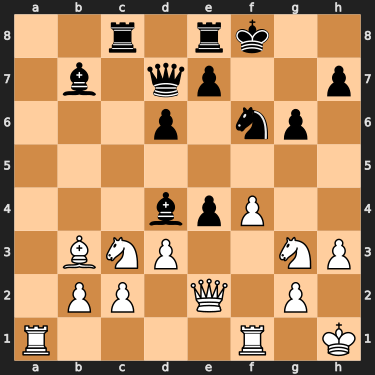


centipawn evaluation of ⬆️ position: 136


In [124]:
evaluate_fen("2r1rk2/1b1qp2p/3p1np1/8/3bpP2/1BNP2NP/1PP1Q1P1/R4R1K w - - 0 26")

chess.com evaluates the ⬆️ position at 320.

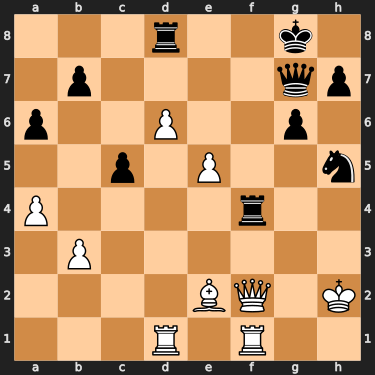


centipawn evaluation of ⬆️ position: -36


In [125]:
evaluate_fen("3r2k1/1p4qp/p2P2p1/2p1P2n/P4r2/1P6/4BQ1K/3R1R2 w - - 0 33")

chess.com evalautes the ⬆️ position at -100.

## final thoughts

while our model could certainly be more accurate, we do have something working as intended.

our model can take in a FEN string, predict its evaluation in centipawns, and then display the position and its prediction.

i'm quite disappointed that our `fen_array` had to be split into 64 separate columns. i'll have to research how we can get a model to accept this type of input.

in the future, i'd like to:
- revisit giving the board position as a tensor or array instead of using columns for each square on the board
- try more models (with different configurations)
- use more of the training data (we only used 5% to stay under our colab RAM limits)
- train for longer